# NOMAD API Authentication

This notebook demonstrates how to authenticate with the NOMAD API using the utilities from the `nomad_api` package.

In [ ]:
# Import the authentication module from the nomad_api package
import os
import sys
import json
import pandas as pd
from pathlib import Path

# Add parent directory to path if needed
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from nomad_api.auth import authenticate, OASIS_OPTIONS, get_token, verify_token

## Available NOMAD Instances

The authentication module defines several NOMAD instances you can connect to:

In [5]:
# Display available NOMAD instances
print("Available NOMAD instances:")
for name, url in OASIS_OPTIONS.items():
    print(f"- {name}: {url}")


Available NOMAD instances:
- SE Oasis: https://nomad-hzb-se.de/nomad-oasis/api/v1
- CE Oasis: https://nomad-hzb-ce.de/nomad-oasis/api/v1
- Sol-AI Oasis: https://nomad-sol-ai.de/nomad-oasis/api/v1


In [6]:

# Set the instance you want to use
selected_instance = "SE Oasis"  # Change this to your desired instance
base_url = OASIS_OPTIONS[selected_instance]
print(f"\nUsing instance: {selected_instance} ({base_url})")


Using instance: SE Oasis (https://nomad-hzb-se.de/nomad-oasis/api/v1)


## Authentication Methods

There are several ways to authenticate with the NOMAD API:

1. **Auto method**: Tries to use token from environment, then username/password from environment
2. **Token method**: Uses the NOMAD_CLIENT_ACCESS_TOKEN environment variable
3. **Password method**: Uses username and password provided directly

Below are examples of each method:

### Method 1: Automatic Authentication (Recommended)

This method tries various authentication sources in sequence.

In [7]:
try:
    token, user_info = authenticate(base_url, method="auto")
    print(f"Successfully authenticated as: {user_info.get('name', user_info.get('username', 'Unknown user'))}")
    print(f"Your user ID: {user_info.get('user_id', 'Unknown')}")
    print(f"\nToken (first 20 chars): {token[:20]}...")
except ValueError as e:
    print(f"Authentication failed: {e}")

Successfully authenticated as: Paolo Graniero
Your user ID: 36705df2-2d25-4421-a247-2995ef5cdcc0

Token (first 20 chars): eyJhbGciOiJSUzI1NiIs...


In [8]:
client = NomadClient(base_url, token)

In [12]:
# General structure:
# client.make_request(method, endpoint, params=None, json_data=None, timeout=10)

headers = {"Authorization": f"Bearer {token}", "page_size": 100}
response = client.make_request("get", "uploads", params=headers)

In [13]:
len(response["data"])

94

In [15]:
response["data"][0].keys()

dict_keys(['process_running', 'current_process', 'process_status', 'last_status_message', 'errors', 'warnings', 'complete_time', 'upload_id', 'upload_name', 'upload_create_time', 'main_author', 'coauthors', 'coauthor_groups', 'reviewers', 'reviewer_groups', 'writers', 'writer_groups', 'viewers', 'viewer_groups', 'published', 'published_to', 'with_embargo', 'embargo_length', 'license', 'entries', 'upload_files_server_path'])

In [27]:
# Define the query payload
query_payload = {
    "owner": "visible",
    "query": {
        "and": [
            {"results.eln.sections:any": ["HySprint_Sample"]},
            {"quantities:all": ["data"]},
        ]
    },
}

# Make sure the client has the token - the NomadClient should handle authentication automatically
response_entries = client.make_request(
    "post", "entries/query", json_data=query_payload
)

# Print the number of entries found
print(
    f"Found {response_entries.get('pagination', {}).get('total', 0)} matching entries"
)


Found 1363 matching entries


In [38]:
response_entries['data'][0]

{'upload_id': 'tMZ_IUSbQGSyMWy8cb_BYQ',
 'references': [],
 'origin': 'Paolo Graniero',
 'text_search_contents': ['pin',
  'Test experiment HZB_PaGr_20240527_Test-experiment_1_2',
  'HZB_PaGr_20240527_Test-experiment_1_2'],
 'quantities': ['',
  'data',
  'data.architecture',
  'data.datetime',
  'data.lab_id',
  'data.name',
  'data.substrate',
  'metadata',
  'metadata.coauthor_groups',
  'metadata.coauthors',
  'metadata.datasets',
  'metadata.embargo_length',
  'metadata.entry_coauthors',
  'metadata.entry_create_time',
  'metadata.entry_hash',
  'metadata.entry_id',
  'metadata.entry_name',
  'metadata.entry_references',
  'metadata.entry_references.source_name',
  'metadata.entry_references.source_path',
  'metadata.entry_references.source_quantity',
  'metadata.entry_references.target_entry_id',
  'metadata.entry_references.target_mainfile',
  'metadata.entry_references.target_name',
  'metadata.entry_references.target_path',
  'metadata.entry_references.target_reference',
  'me

In [46]:
sample_id = response_entries['data'][0]['data']['lab_id']


'HZB_PaGr_20240527_Test-experiment_1_2'

In [41]:
upload_id = response_entries['data'][0]['upload_id']
upload_id

'tMZ_IUSbQGSyMWy8cb_BYQ'

In [42]:
#get upload details
response_upload = client.make_request(
    "get", f"uploads/{upload_id}", params={"page_size": 100}
)

In [47]:
# example upload:
# {
#     "upload_id": "tMZ_IUSbQGSyMWy8cb_BYQ",
#     "data": {
#         "process_running": False,
#         "current_process": "process_upload",
#         "process_status": "SUCCESS",
#         "last_status_message": "Process process_upload completed successfully",
#         "errors": [],
#         "warnings": [],
#         "complete_time": "2024-10-08T20:18:58.057000",
#         "upload_id": "tMZ_IUSbQGSyMWy8cb_BYQ",
#         "upload_name": "kghfk",
#         "upload_create_time": "2024-05-27T12:59:39.741000",
#         "main_author": "36705df2-2d25-4421-a247-2995ef5cdcc0",
#         "coauthors": [],
#         "coauthor_groups": [],
#         "reviewers": [],
#         "reviewer_groups": [],
#         "writers": ["36705df2-2d25-4421-a247-2995ef5cdcc0"],
#         "writer_groups": [],
#         "viewers": ["36705df2-2d25-4421-a247-2995ef5cdcc0"],
#         "viewer_groups": [],
#         "published": False,
#         "published_to": [],
#         "with_embargo": False,
#         "embargo_length": 0,
#         "license": "CC BY 4.0",
#         "entries": 42,
#         "upload_files_server_path": "/home/ubuntu/nomad-oasis/.volumes/fs/staging/tM/tMZ_IUSbQGSyMWy8cb_BYQ",
#     },
# }
main_author = response_upload['data']['main_author']
coauthors = response_upload['data']['coauthors']
coauthor_groups = response_upload['data']['coauthor_groups']
upload_create_time = response_upload['data']['upload_create_time']

print(f"Main Author: {main_author}")
print(f"Co-authors: {coauthors}")
print(f"Co-author Groups: {coauthor_groups}")
print(f"Upload Create Time: {upload_create_time}")

Main Author: 36705df2-2d25-4421-a247-2995ef5cdcc0
Co-authors: []
Co-author Groups: []
Upload Create Time: 2024-05-27T12:59:39.741000


# Collect Author Information for All Samples

This section demonstrates how to collect information about authors for all samples in the NOMAD database.

In [49]:
# Import necessary modules from the nomad_api package
from nomad_api.client import NomadClient
import pandas as pd
import datetime
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Function to retrieve all samples with author information
def get_all_samples_with_authors(client, page_size=100, max_pages=None):
    """
    Retrieve all samples with their author information
    
    Args:
        client: NomadClient instance
        page_size: Number of entries per page
        max_pages: Maximum number of pages to retrieve (None for all)
        
    Returns:
        List of dictionaries with sample data and author information
    """
    samples_with_authors = []
    page = 1
    total_pages = float('inf')  # Will be updated after first query
    
    # Query for samples (entries with HySprint_Sample sections)
    query_payload = {
        "owner": "visible",
        "query": {
            "and": [
                {"results.eln.sections:any": ["HySprint_Sample"]},
                {"quantities:all": ["data"]},
            ]
        },
        "pagination": {
            "page_size": page_size,
            "page": page
        }
    }
    
    print("Retrieving samples with author information...")
    
    while page <= total_pages and (max_pages is None or page <= max_pages):
        # Update pagination for the current page
        query_payload['pagination']['page'] = page
        
        # Get entries for the current page
        response_entries = client.make_request("post", "entries/query", json_data=query_payload)
        
        # Update total pages on first query
        if page == 1:
            total_entries = response_entries.get('pagination', {}).get('total', 0)
            total_pages = (total_entries + page_size - 1) // page_size
            print(f"Found {total_entries} samples (approximately {total_pages} pages)")
            
            if max_pages:
                print(f"Limiting to {max_pages} pages ({min(max_pages * page_size, total_entries)} samples)")
        
        entries = response_entries.get('data', [])
        
        # Process entries in current page
        for entry in entries:
            try:
                # Extract basic sample information
                sample_info = {
                    'entry_id': entry.get('entry_id'),
                    'upload_id': entry.get('upload_id'),
                    'lab_id': entry.get('data', {}).get('lab_id')
                }
                
                # Get details about the upload (which contains author information)
                upload_id = entry.get('upload_id')
                if upload_id:
                    response_upload = client.make_request("get", f"uploads/{upload_id}")
                    upload_data = response_upload.get('data', {})
                    
                    # Add author information
                    sample_info.update({
                        'main_author': upload_data.get('main_author'),
                        'coauthors': upload_data.get('coauthors', []),
                        'coauthor_groups': upload_data.get('coauthor_groups', []),
                        'upload_create_time': upload_data.get('upload_create_time'),
                        'published': upload_data.get('published', False),
                        'license': upload_data.get('license'),
                        'upload_name': upload_data.get('upload_name'),
                    })
                
                samples_with_authors.append(sample_info)
                
            except Exception as e:
                print(f"Error processing entry {entry.get('entry_id')}: {str(e)}")
        
        print(f"Processed page {page}/{total_pages if max_pages is None else min(max_pages, total_pages)}")
        page += 1
    
    print(f"Retrieved information for {len(samples_with_authors)} samples")
    return samples_with_authors

In [51]:
# Get all samples with author information (limiting to 5 pages for testing)
# Remove the max_pages parameter to get all samples
samples_data = get_all_samples_with_authors(client, page_size=50, max_pages=5)

Retrieving samples with author information...
Found 1363 samples (approximately 28 pages)
Limiting to 5 pages (250 samples)
Processed page 1/5
Processed page 2/5
Processed page 3/5
Processed page 4/5
Processed page 5/5
Retrieved information for 250 samples


In [52]:
# Convert to DataFrame for easier analysis
samples_df = pd.DataFrame(samples_data)

# Display the first few rows
samples_df.head()

,entry_id,upload_id,lab_id,main_author,coauthors,coauthor_groups,upload_create_time,published,license,upload_name
0,-20CjHDeyUtPDI4E7EpFo-K5JFH-,tMZ_IUSbQGSyMWy8cb_BYQ,HZB_PaGr_20240527_Test-experiment_1_2,36705df2-2d25-4421-a247-2995ef5cdcc0,[],[],2024-05-27T12:59:39.741000,False,CC BY 4.0,kghfk
1,-3UKqP7Vk3XDl0HnOMe5GuWaIhNS,Yk5i_GB3RQqMEO3mIURIsg,HZB_RiMe_20240312_KW_10_Module_Baseline_14_0,e9e2df2f-5332-417e-9ae2-c5f1fc253678,"[925f6ddd-0270-4bd3-a413-96a4ddabde5b, f0d8a33...",[],2024-03-12T08:49:32.352000,False,CC BY 4.0,KW10 Module Baseline
2,-635Z62MBAoFkXDxqYfamU3qcgCX,Uq7aoxCCRKe0g2sprkDbMg,HZB_MMB_8-2002-3-0,df8bc696-58aa-4571-95fb-d71a800e1c07,[],[MjM4ze-URpu0NrHBulkRYg],2025-03-19T11:06:57.233000,False,CC BY 4.0,MMB Batch 2002
3,-EpU21KcOHh9-kpxTbEOo45o5WkX,SsIwhyaWT4amgUlZjjNHbQ,HZB_Solartap recipe_46_1_C-2,cd74ddd3-78e1-48dc-b2f3-f7f430e94d2d,[36705df2-2d25-4421-a247-2995ef5cdcc0],[],2025-03-19T16:03:53.726000,False,CC BY 4.0,Yanyan Solartap recipe-batch 46 First batch fo...
4,-EqVUCMOvMbkkS9YCTlUBEQosfHj,NbVxs9BoQ4GJH8b7nX-TbA,HZB_PaGr_20240227_test-pres_2_2,36705df2-2d25-4421-a247-2995ef5cdcc0,[],[],2024-02-27T10:45:41.111000,False,CC BY 4.0,None


In [53]:
# Save the data to CSV for backup and further analysis
samples_df.to_csv('nomad_samples_with_authors.csv', index=False)
print(f"Data saved to 'nomad_samples_with_authors.csv'")

Data saved to 'nomad_samples_with_authors.csv'


# Enriching Author Information

To make the data more useful for dashboards, let's enrich it by retrieving user details for the author IDs.

In [55]:
# Function to get user details by user_id
def get_user_details(client, user_id):
    """Get detailed information about a user by their ID"""
    try:
        response = client.make_request('get', f'users/{user_id}')
        return response
    except Exception as e:
        print(f"Error getting user {user_id}: {str(e)}")
        return None

In [56]:
# Create a dictionary to store user details (to avoid duplicate API calls)
user_cache = {}

# Get unique author IDs
unique_authors = set(samples_df['main_author'].unique())
for coauthors_list in samples_df['coauthors'].dropna():
    if isinstance(coauthors_list, list):
        unique_authors.update(coauthors_list)

print(f"Found {len(unique_authors)} unique authors")

Found 31 unique authors


In [57]:
# Retrieve user details for each unique author
for user_id in unique_authors:
    if user_id and user_id not in user_cache:
        user_details = get_user_details(client, user_id)
        if user_details:
            user_cache[user_id] = user_details
            
print(f"Retrieved details for {len(user_cache)} users")

Retrieved details for 31 users


In [58]:
# Create a mapping from user ID to user name for easier reference
user_id_to_name = {}

for user_id, user_info in user_cache.items():
    name = user_info.get('name') or user_info.get('username', 'Unknown')
    user_id_to_name[user_id] = name

# Add user names to the DataFrame
samples_df['main_author_name'] = samples_df['main_author'].map(lambda x: user_id_to_name.get(x, 'Unknown'))

# For coauthors (which is a list), add a new column with names
def get_coauthor_names(coauthor_ids):
    if not isinstance(coauthor_ids, list):
        return []
    return [user_id_to_name.get(user_id, 'Unknown') for user_id in coauthor_ids]

samples_df['coauthor_names'] = samples_df['coauthors'].apply(get_coauthor_names)

# Data Analysis and Dashboard Preparation

Now let's analyze the data and create some visualizations for our dashboard.

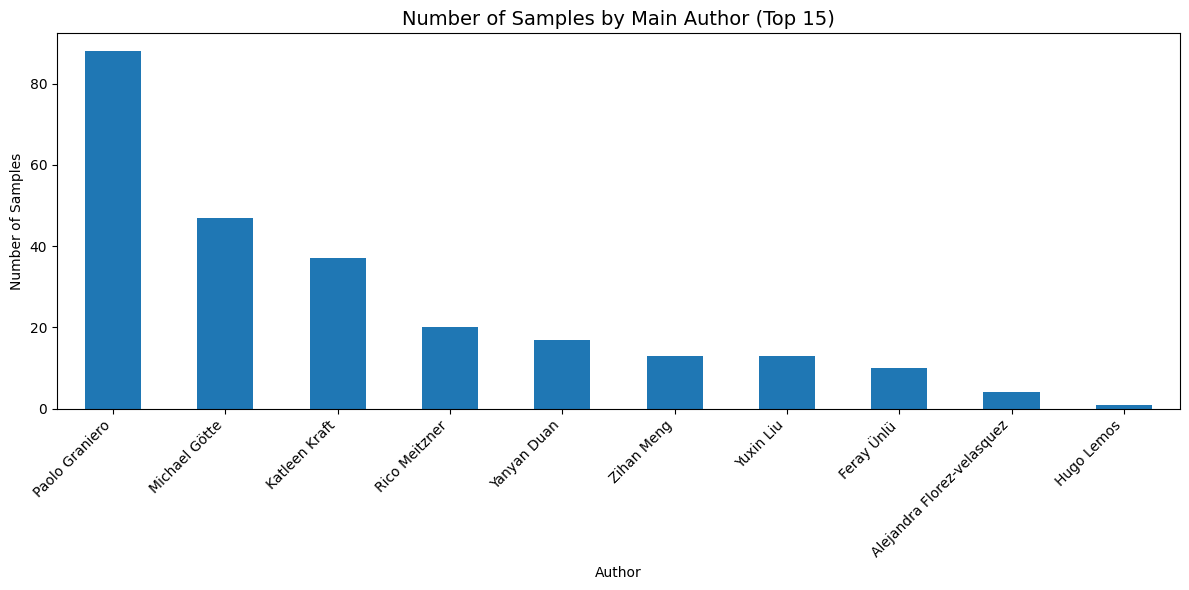

In [59]:
# 1. Count samples per main author
author_sample_counts = samples_df['main_author_name'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))
author_sample_counts.head(15).plot(kind='bar')
plt.title('Number of Samples by Main Author (Top 15)', fontsize=14)
plt.xlabel('Author')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

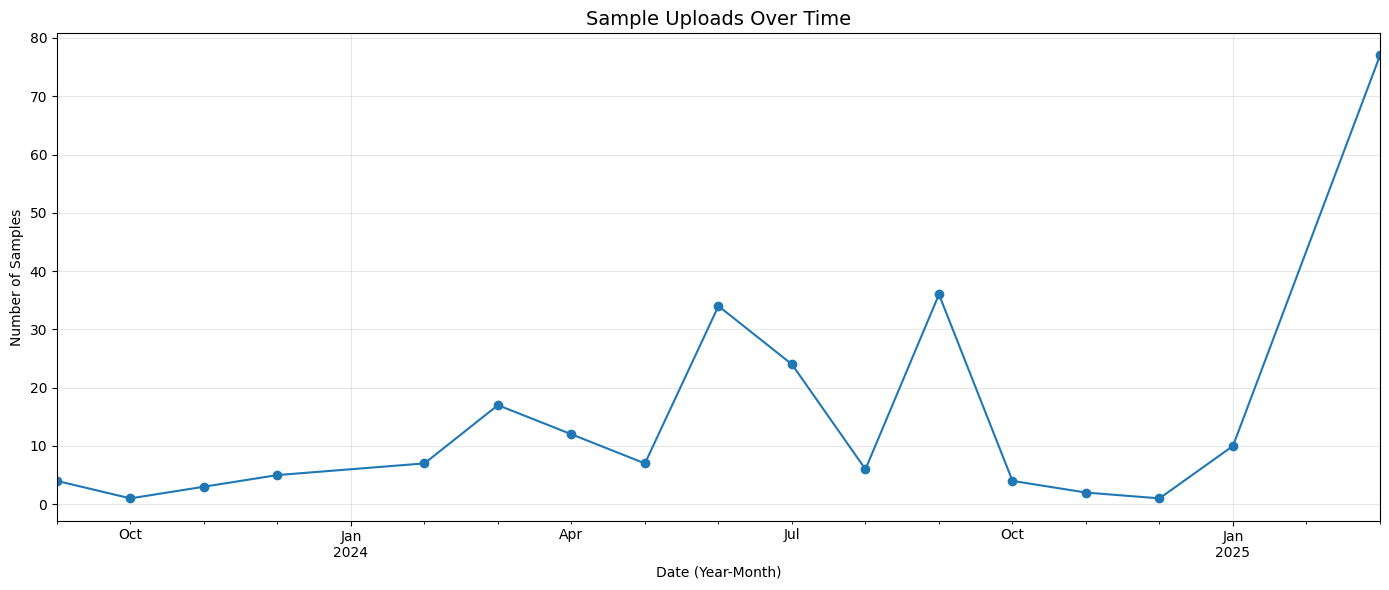

In [60]:
# 2. Analyze sample creation over time

# Convert upload_create_time to datetime
samples_df['upload_date'] = pd.to_datetime(samples_df['upload_create_time'])

# Extract year and month for time series analysis
samples_df['year_month'] = samples_df['upload_date'].dt.to_period('M')

# Count samples by month
time_series = samples_df.groupby('year_month').size()

# Plot time series
plt.figure(figsize=(14, 6))
time_series.plot(kind='line', marker='o')
plt.title('Sample Uploads Over Time', fontsize=14)
plt.xlabel('Date (Year-Month)')
plt.ylabel('Number of Samples')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

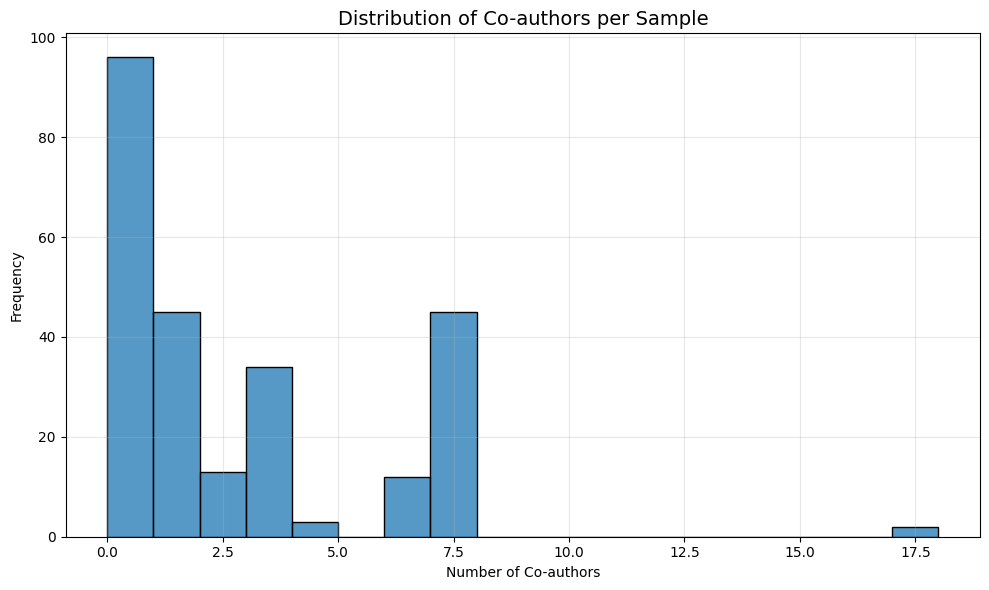

In [61]:
# 3. Analyze collaboration patterns (co-authorship)

# Count number of coauthors per sample
samples_df['coauthor_count'] = samples_df['coauthors'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Plot distribution of number of coauthors
plt.figure(figsize=(10, 6))
sns.histplot(samples_df['coauthor_count'], bins=range(0, max(samples_df['coauthor_count'])+2))
plt.title('Distribution of Co-authors per Sample', fontsize=14)
plt.xlabel('Number of Co-authors')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [62]:
# 4. Create collaboration network data (for network visualization)
collaborations = []

# For each sample, create pairs of collaborating authors
for _, row in samples_df.iterrows():
    main_author = row['main_author']
    main_author_name = row['main_author_name']
    
    # Add collaboration between main author and each co-author
    coauthors = row['coauthors']
    if isinstance(coauthors, list) and len(coauthors) > 0:
        for coauthor in coauthors:
            coauthor_name = user_id_to_name.get(coauthor, 'Unknown')
            collaborations.append((main_author_name, coauthor_name))

# Count frequency of each collaboration
from collections import Counter
collaboration_counts = Counter(collaborations)

# Print the top 10 most frequent collaborations
print("Top 10 collaborations:")
for collab, count in collaboration_counts.most_common(10):
    print(f"{collab[0]} ↔ {collab[1]}: {count} samples")

Top 10 collaborations:
Michael Götte ↔ Janardan Dagar: 46 samples
Michael Götte ↔ Pramila Patil: 46 samples
Michael Götte ↔ Eva Unger: 46 samples
Michael Götte ↔ Edgar Nandayapa: 46 samples
Michael Götte ↔ Rico Meitzner: 46 samples
Michael Götte ↔ Paolo Graniero: 46 samples
Michael Götte ↔ Anton Dzhong: 42 samples
Paolo Graniero ↔ Janardan Dagar: 21 samples
Rico Meitzner ↔ Paolo Graniero: 20 samples
Rico Meitzner ↔ Michael Götte: 20 samples


# Prepare Data for Interactive Dashboard

Let's prepare and save structured data for an interactive dashboard.

In [65]:
# Convert our dataframe to more dashboard-friendly formats

# 1. Summary statistics
dashboard_stats = {
    'total_samples': int(len(samples_df)),
    'total_authors': int(len(unique_authors)),
    'published_samples': int(samples_df['published'].sum()),
    'private_samples': int(len(samples_df) - samples_df['published'].sum()),
    'samples_with_coauthors': int((samples_df['coauthor_count'] > 0).sum()),
    'avg_coauthors_per_sample': float(samples_df['coauthor_count'].mean()),
    'most_prolific_author': str(author_sample_counts.index[0]),
    'most_prolific_author_count': int(author_sample_counts.iloc[0]),
    'most_recent_upload': samples_df['upload_date'].max().strftime('%Y-%m-%d'),
    'oldest_upload': samples_df['upload_date'].min().strftime('%Y-%m-%d'),
}

# Save summary stats
with open('dashboard_summary_stats.json', 'w') as f:
    json.dump(dashboard_stats, f, indent=2)

print("Summary statistics saved for dashboard")

Summary statistics saved for dashboard


In [67]:
# 2. Time series data (monthly uploads)
time_series_data = {
    'dates': [str(period) for period in time_series.index],
    'counts': [int(count) for count in time_series.values]  # Convert numpy.int64 to Python int
}

# Save time series data
with open('dashboard_time_series.json', 'w') as f:
    json.dump(time_series_data, f)

# 3. Author statistics
author_stats = []
for author_name, count in author_sample_counts.items():
    # Get author ID
    author_id = None
    for id, name in user_id_to_name.items():
        if name == author_name:
            author_id = id
            break
            
    author_stats.append({
        'author_name': author_name,
        'author_id': author_id,
        'sample_count': int(count),
        # Additional metrics could be added here
    })

# Save author statistics
with open('dashboard_author_stats.json', 'w') as f:
    json.dump(author_stats, f, indent=2)

# 4. Collaboration network data
network_data = {
    'nodes': [{'id': author, 'group': 1, 'size': author_sample_counts.get(author, 1)} 
              for author in set(user_id_to_name.values())],
    'links': [{'source': source, 'target': target, 'value': count} 
              for (source, target), count in collaboration_counts.items()]
}

# Save network data
with open('dashboard_network.json', 'w') as f:
    # Convert any NumPy types to Python native types
    network_data_serializable = json.loads(
        json.dumps(network_data, default=lambda x: int(x) if hasattr(x, 'dtype') else x)
    )
    json.dump(network_data_serializable, f, indent=2)

print("Data for interactive dashboard saved successfully.")

Data for interactive dashboard saved successfully.


# Summary

We've collected comprehensive author information for all samples from NOMAD, structured this data for analysis, and created visualizations. The data has been saved in formats suitable for building interactive dashboards.

The following files were created:

1. `nomad_samples_with_authors.csv` - Raw data with all samples and their author information
2. `dashboard_summary_stats.json` - Summary statistics for the dashboard
3. `dashboard_time_series.json` - Time series data for charts
4. `dashboard_author_stats.json` - Detailed author statistics
5. `dashboard_network.json` - Collaboration network data for network visualizations

These can be used with dashboard frameworks like Plotly Dash, Streamlit, or web-based visualization libraries like D3.js to create interactive dashboards.